In [2]:
#Se importan las librerias necesarias para tratar el dataset
%matplotlib inline
from time import time
import glob
import os
import re
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import svm
import numpy as np
import pandas as pd
import PIL
import random
from PIL import Image

/home/ejrueda/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def natural_key(string_):
    
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', string_)]

In [4]:
TRAIN_DIR = './data/train/'

In [6]:
train_cats = sorted(glob.glob(os.path.join(TRAIN_DIR, 'cat*.jpg')), key=natural_key)
train_dogs = sorted(glob.glob(os.path.join(TRAIN_DIR, 'dog*.jpg')), key=natural_key)
train_all = train_cats + train_dogs

16140 ./data/train/dog.3640.jpg (386, 309)


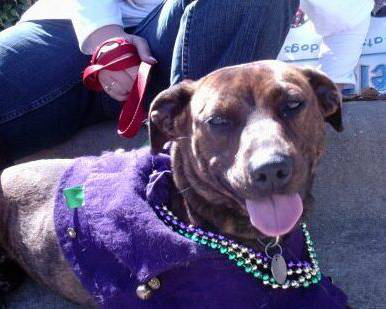

In [9]:
index=int(np.random.random()*25000)
print(index,format(train_all[index]),Image.open(train_all[index]).size)
Image.open(train_all[index])

In [10]:
tiempo_inicial = time()
t_m=5000
t_r=100
image_p = np.zeros((t_m,100*100))
for i in range(t_m):
    image_p[i]=(np.mean(np.asarray(Image.open(train_all[i]).resize((t_r,t_r)),
                                   dtype=np.float64),axis=2)).reshape(1,t_r**2)
tiempo_final = time()
print(tiempo_final-tiempo_inicial)

14.712118148803711


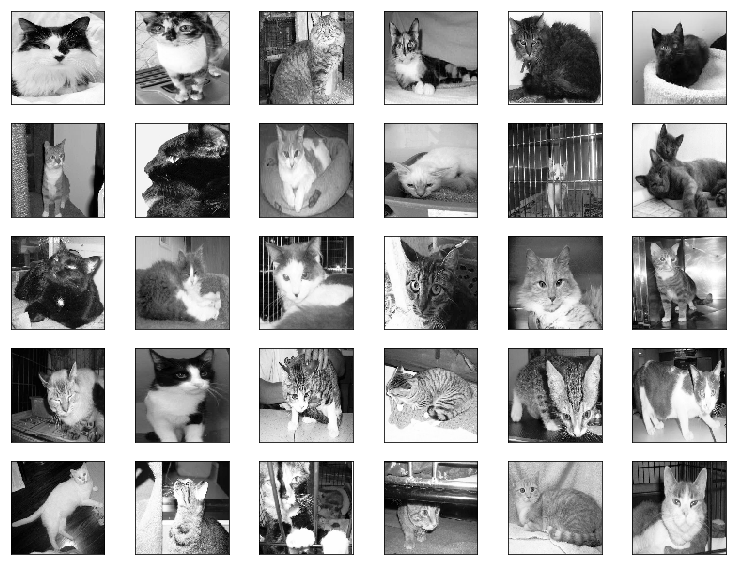

In [13]:
fig = plt.figure(figsize=(13,10))
for i in range(30):
    fig.add_subplot(5,6,(i+1),xticks=[], yticks=[])
    num=int(np.random.random()*5000)
    #plt.title("{}".format(y_train[num]))
    plt.imshow(image_p[num].reshape(100,100),cmap = plt.cm.Greys_r)

In [14]:
import os
import numpy as np
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

class GANs:
    #inicialización de variables
    def __init__(self, width=100, height=100, channels=1):
        #para retornar las imágenes
        self.WIDTH = width
        self.HEIGHT = height
        self.CHANNELS = channels
        self.SHAPE = (width, height, channels)
        #self.optimizer = Adam(lr=0.0001, beta_1=0.5, decay=8e-8)
        self.optimizer = Adam(lr=0.0001, beta_1=0.5)
        self.G = self.noise_generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        #print("Compilando el generador...")
        self.D = self.discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        #print("Compilando el discriminador...")
        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()
        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        
    #Para unir el generador y el disctiminador
    def __stacked_generator_discriminator(self):
        self.D.trainable = False
        model = Sequential()
        model.add(self.G)
        model.add(self.D)
        return model
    
    #generador de ruido
    def noise_generator(self):
        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        #model.add(Dropout(0.1))
        model.add(BatchNormalization(momentum=0.8)) #normalización de las capas anteriores
        model.add(Dense(512))
        #model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        #model.add(Dropout(0.1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.WIDTH  * self.HEIGHT * self.CHANNELS, activation='tanh'))
        model.add(Reshape((self.WIDTH, self.HEIGHT, self.CHANNELS)))
        return model

    #Discriminador del modelo
    def discriminator(self):    
        model = Sequential()
        model.add(Flatten(input_shape=self.SHAPE))
        model.add(Dense((self.WIDTH * self.HEIGHT * self.CHANNELS), input_shape=self.SHAPE))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(np.int64((self.WIDTH * self.HEIGHT * self.CHANNELS)/2)))
        model.add(LeakyReLU(alpha=0.2))
        #model.add(Dropout(0.1))
        model.add(Dense(1, activation='sigmoid'))
        #model.summary()
        return model
    
    #Entrenar la GANs
    def train(self, X_train, epochs, batch):
        ## train discriminator
        Imgs = []
        for cnt in range(epochs):
            random_index = np.random.randint(0, len(X_train) - np.int64(batch/2))
            #print(random_index)
            legit_images = X_train[random_index:random_index + np.int64(batch/2)].reshape(np.int64(batch/2),
                                                                                            self.WIDTH,
                                                                                            self.HEIGHT,
                                                                                            self.CHANNELS)
            gen_noise = np.random.normal(0, 1, (np.int64(batch/2), 100))
            #print(gen_noise.shape)
            syntetic_images = self.G.predict(gen_noise)
            #print(legit_images.shape, syntetic_images.shape)
            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)),
                                               np.zeros((np.int64(batch/2), 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator
            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0],
                                                                                           g_loss))
            #bined_batch = np.concatenate((np.ones((np.int64(batch/2), 1)), np.zeros((np.int64(batch/2), 1))))
            if (cnt % 100) ==0: #para dibujar solos módulos de 100
                Imgs.append(self.plot_images(save2file=True, samples=20, step=cnt))
                print(np.array(Imgs).shape)
        return Imgs
            
    def plot_images(self, save2file=False, samples=20, step=0):
        # Para pintar o guardar las imágenes
        if not os.path.exists("./images"):
            os.makedirs("./images")
        filename = "./images/mnist_" + str(step) + ".png"
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)
        #print(images.shape)
        plt.figure(figsize=(10, 10))

        for i in range(images.shape[0]):
            plt.subplot(4, 5, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.HEIGHT, self.WIDTH])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()
        return images

In [15]:
X_train = np.expand_dims(image_p, axis=3)
X_train.shape

/home/ejrueda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """Entry point for launching an IPython kernel.


(5000, 10000, 1)

In [ ]:
gan = GANs()
l_img = gan.train(X_train,epochs=500,batch=128)

/home/ejrueda/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch: 0, [Discriminator :: d_loss: 1.746901], [ Generator :: loss: 0.358456]
(1, 20, 100, 100, 1)
epoch: 1, [Discriminator :: d_loss: 0.722902], [ Generator :: loss: 0.590194]
epoch: 2, [Discriminator :: d_loss: 0.509862], [ Generator :: loss: 1.396777]
epoch: 3, [Discriminator :: d_loss: 0.210700], [ Generator :: loss: 2.244301]
epoch: 4, [Discriminator :: d_loss: 0.095821], [ Generator :: loss: 2.954308]
epoch: 5, [Discriminator :: d_loss: 0.049089], [ Generator :: loss: 3.318249]
epoch: 6, [Discriminator :: d_loss: 0.033246], [ Generator :: loss: 3.481497]
epoch: 7, [Discriminator :: d_loss: 0.027930], [ Generator :: loss: 3.439721]
epoch: 8, [Discriminator :: d_loss: 0.032189], [ Generator :: loss: 3.371801]
epoch: 9, [Discriminator :: d_loss: 0.033273], [ Generator :: loss: 3.245896]
epoch: 10, [Discriminator :: d_loss: 0.038174], [ Generator :: loss: 3.272707]
epoch: 11, [Discriminator :: d_loss: 0.036629], [ Generator :: loss: 3.151231]
epoch: 12, [Discriminator :: d_loss: 0.03

epoch: 104, [Discriminator :: d_loss: 4.656071], [ Generator :: loss: 7.113112]
epoch: 105, [Discriminator :: d_loss: 4.442721], [ Generator :: loss: 6.234398]
epoch: 106, [Discriminator :: d_loss: 3.969322], [ Generator :: loss: 6.977355]
epoch: 107, [Discriminator :: d_loss: 4.483796], [ Generator :: loss: 6.799821]
epoch: 108, [Discriminator :: d_loss: 4.086361], [ Generator :: loss: 6.862381]
epoch: 109, [Discriminator :: d_loss: 4.735309], [ Generator :: loss: 6.569786]
epoch: 110, [Discriminator :: d_loss: 4.366770], [ Generator :: loss: 7.169858]
epoch: 111, [Discriminator :: d_loss: 3.487397], [ Generator :: loss: 6.531265]
epoch: 112, [Discriminator :: d_loss: 4.820001], [ Generator :: loss: 7.666450]
epoch: 113, [Discriminator :: d_loss: 4.110200], [ Generator :: loss: 6.596644]
epoch: 114, [Discriminator :: d_loss: 4.809245], [ Generator :: loss: 6.452785]
epoch: 115, [Discriminator :: d_loss: 4.079466], [ Generator :: loss: 6.908926]
epoch: 116, [Discriminator :: d_loss: 4.

epoch: 207, [Discriminator :: d_loss: 9.436085], [ Generator :: loss: 13.735801]
epoch: 208, [Discriminator :: d_loss: 9.153284], [ Generator :: loss: 13.549975]
epoch: 209, [Discriminator :: d_loss: 10.279909], [ Generator :: loss: 13.052783]
epoch: 210, [Discriminator :: d_loss: 9.344618], [ Generator :: loss: 13.499111]
epoch: 211, [Discriminator :: d_loss: 8.598816], [ Generator :: loss: 13.350592]
epoch: 212, [Discriminator :: d_loss: 8.909237], [ Generator :: loss: 13.473722]
epoch: 213, [Discriminator :: d_loss: 8.806349], [ Generator :: loss: 14.164852]
epoch: 214, [Discriminator :: d_loss: 8.742591], [ Generator :: loss: 14.224751]
epoch: 215, [Discriminator :: d_loss: 8.703460], [ Generator :: loss: 15.421616]
epoch: 216, [Discriminator :: d_loss: 8.434219], [ Generator :: loss: 15.978378]
epoch: 217, [Discriminator :: d_loss: 8.059048], [ Generator :: loss: 16.003101]
epoch: 218, [Discriminator :: d_loss: 8.059048], [ Generator :: loss: 16.001911]
epoch: 219, [Discriminator 